In [1]:
import sys
sys.path.append('../src')
from CAPM import CAPM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 🖇 Step 1: Loading Data
The `CAPM` class requires two separate inputs: a dataset of individual asset returns, and corresponding market returns (typically the S&P 500).

When preparing your data, please note the following:

1. Your **assets data must be a Pandas `DataFrame`**, and your **market data must be a Pandas `Series`**.
   In both cases, the index must represent dates. While the index does not have to be explicitly of datetime type, the `CAPM` class will automatically attempt to convert it using `pd.to_datetime()` if needed.

2. Your assets data and market data **do not need to be the exact same length**, but a misalignment of more than a few days may introduce bias and degrade model accuracy.

3. Both the assets and market inputs **must be in log-return format**.
   The class will internally convert log-returns into relative returns when producing final outputs such as Sharpe and Treynor ratios.

In [2]:
close_prices = pd.read_csv("../data/100 close prices 5Y.csv").set_index('date').dropna()
market = pd.read_csv("../data/SP500_Close_5Y.csv").set_index('Date')

# Since merkaet is a pandas dataframe, we have to convert it first into a Series:
market = pd.Series(data=market.values.reshape(-1),
          index=market.index)

In [3]:
print(f'Stocks data range: {close_prices.index[0], close_prices.index[-1]}')
print(f'Market data range: {market.index[0], market.index[1]}')

Stocks data range: ('2020-05-19', '2025-05-16')
Market data range: ('2020-05-19', '2020-05-20')


In [4]:
# Turning the data into log returns.
# Just for convenience, I will sample random 30 stocks from the data.
close_logs = np.log(close_prices/close_prices.shift()).dropna().sample(30, axis=1)
market_logs = np.log(market / market.shift()).dropna()

# 🟢 Step 2: Calling the ```CAPM``` Class
📌 **Note**:  Similarly to the `MeanVarOpt` class, the `CAPM` class provides basic properties such as `correlation_matrix` and `covariance_matrix`.  
For more information about these attributes and how they are computed, please refer to the documentation of the `MinVarOpt` class.

In [5]:
capm = CAPM(close_logs, r_free=0.035, market_data=market_logs)

INFO:root:DataFrame index type: Index was automatically converted into pd.DatetimeIndex.
INFO:root:market_data index type: <class 'pandas.core.indexes.base.Index'> was automatically converted into pd.DatetimeIndex.


### `get_cml_curve`
The `get_cml_curve` method returns a Pandas `DataFrame` containing the values of the Capital Market Line (CML) for a range of volatility levels.

You can control the maximum volatility to include in the curve by setting the `max_vol` parameter (default is `1.0`), and the amount of values be setting the ```points``` parameter (deafult is ```1000```).

In [6]:
cml = capm.get_cml_curve()
cml.head()

,Volatility,Expected Return
0,0.000000,0.035000
1,0.001001,0.035599
2,0.002002,0.036197
3,0.003003,0.036796
4,0.004004,0.037395


### `plot_cml_curve`
The `plot_cml_curve` method provides a visual representation of your selected assets plotted against the Capital Market Line (CML).

If the chart appears too crowded, you can set the `text` parameter to `False` to disable asset annotations.

It is also highly recommended to use Matplotlib’s `xlim` and `ylim` functions to configure the axes for better visibility and to focus on the assets you wish to examine. 

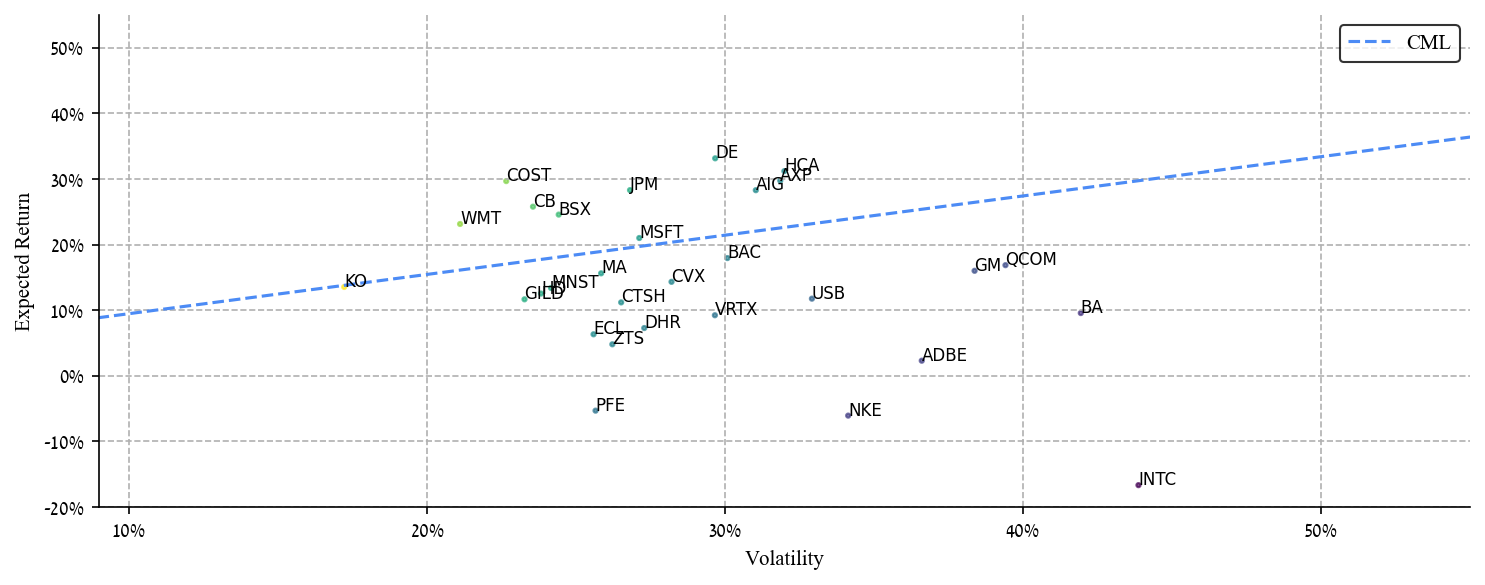

In [8]:
capm.plot_cml_curve()
plt.xlim(0.09, 0.55)
plt.ylim(-0.2, 0.55)
plt.show()

### `ratios`
The `ratios` property returns a Pandas `DataFrame` containing the following performance metrics for each asset:

1. Beta  
2. Sharpe Ratio  
3. Treynor Ratio  

These values allow for an easy comparison of asset performance and risk-adjusted returns. You can readily plot them to visualize the relative efficiency of your assets.

In [9]:
ratios = capm.ratios
ratios.head()

,beta,sharpe,treynor
COST,0.760000,5.570175,1.660310
DHR,0.884884,3.803785,1.172935
DE,0.828214,4.370482,1.565512
MSFT,1.174828,4.333163,1.000252
BSX,0.786101,4.959188,1.540235


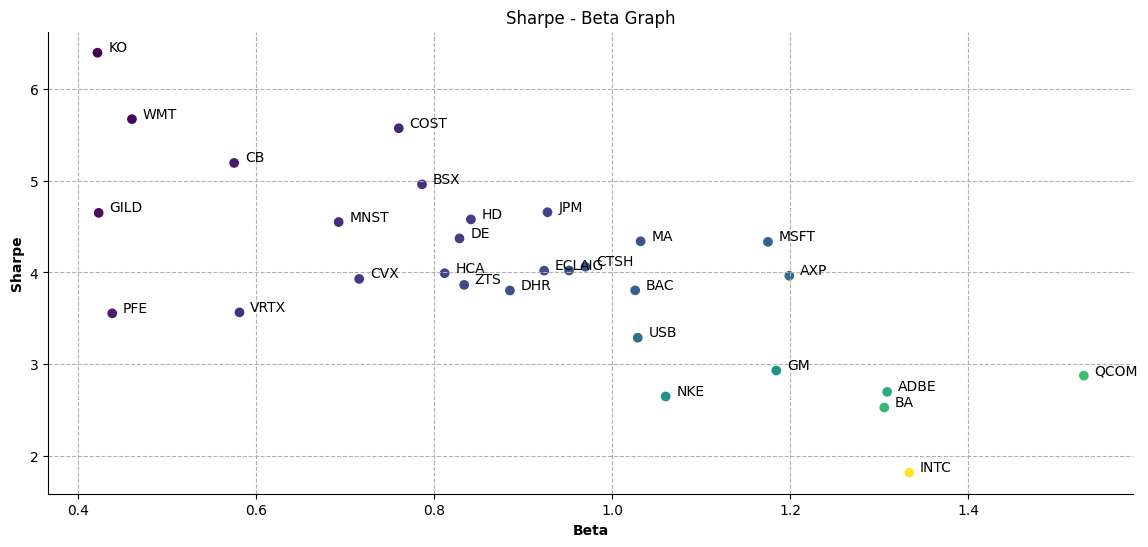

In [10]:
plt.figure(figsize=(14,6))
plt.scatter(ratios['beta'], ratios['sharpe'],
           c=ratios['beta'] / ratios['sharpe'])

for i in ratios.index:
    x = ratios.loc[i, 'beta']
    y = ratios.loc[i, 'sharpe']
    plt.text(x=x+0.012,
            y=y+0.012,
            s=i)

plt.xlabel('Beta', weight='bold')
plt.ylabel('Sharpe', weight='bold')
plt.title('Sharpe - Beta Graph')

plt.grid(ls='--')
sns.despine()
plt.show()